In [1]:
# STEP 1 - INSTALL GENSIM PACKAGE
!pip install gensim
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.9 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# STEP 2 - LOAD THE DATASET

import pandas as pd
df = pd.read_excel("/Users/maryucheononye/Desktop/TheHackerNews_Dataset.xlsx")
texts = df["Article"].fillna("").astype(str).tolist()
print(texts[:20])

['Cloud infrastructure security company Wiz on Thursday revealed details of a now-fixed Azure Cosmos database vulnerability that could have been potentially exploited to grant any Azure user full admin access to other customers\' database instances without any authorization.\nThe flaw, which grants read, write, and delete privileges, has been dubbed "ChaosDB," with Wiz researchers noting that "the vulnerability has a trivial exploit that doesn\'t require any previous access to the target environment, and impacts thousands of organizations, including numerous Fortune 500 companies."\nCosmos DB is Microsoft\'s proprietary NoSQL database that\'s advertised as "a fully managed service" that "takes database administration off your hands with automatic management, updates and patching."\nThe Wiz Research Team reported the issue to Microsoft on August 12, after which the Windows maker took steps to mitigate the issue within 48 hours of responsible disclosure, in addition to awarding a $40,000

In [3]:
# STEP 3 - PREPOCESS USING SPACY ( TOKENIZE + REMOVE STOPWORDS + LEMMATIZE)

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

def preprocess_many(text_list):
    processed = []
    
    # nlp.pipe takes a list (or generator) of our texts and processes them in batches.
    for doc in nlp.pipe((t.lower() for t in text_list), batch_size=20):
        tokens = [
            token.lemma_
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and token.is_alpha
            and len(token) > 3
        ]
        processed.append(tokens)
    
    return processed

# Now we apply it to all our articles
processed_docs = preprocess_many(texts)

print("Number of documents:", len(processed_docs))
print("First doc tokens:", processed_docs[0][:40])

Number of documents: 3742
First doc tokens: ['cloud', 'infrastructure', 'security', 'company', 'thursday', 'reveal', 'detail', 'fix', 'azure', 'cosmos', 'database', 'vulnerability', 'potentially', 'exploit', 'grant', 'azure', 'user', 'admin', 'access', 'customer', 'database', 'instance', 'authorization', 'flaw', 'grant', 'read', 'write', 'delete', 'privilege', 'dub', 'chaosdb', 'researcher', 'note', 'vulnerability', 'trivial', 'exploit', 'require', 'previous', 'access', 'target']


In [4]:
# STEP 4  - CREATE DICTIONARY & CORPUS
from gensim import corpora

# Create dictionary from processed docs
dictionary = corpora.Dictionary(processed_docs)

# remove very rare and very common words
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print("Vocabulary size:", len(dictionary))
print("Sample for first doc:", corpus[0][:10])

Vocabulary size: 6514
Sample for first doc: [(0, 6), (1, 5), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)]


In [5]:
# STEP 5 - RUN GENSIM LDA MODEL
from gensim.models.ldamodel import LdaModel

num_topics = 6  

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha="auto",
    eta="auto"
)

In [6]:
# STEP 6 - PRINT THE TOPICS

for i, topic in lda_model.show_topics(num_topics=6, num_words=10, formatted=False):
    print(f"\nTopic {i}:")
    print(", ".join([word for word, prob in topic]))


Topic 0:
vulnerability, exploit, patch, flaw, code, update, allow, window, version, device

Topic 1:
server, threat, file, malicious, group, campaign, exploit, actor, command, software

Topic 2:
device, android, app, google, phone, mobile, datum, store, application, message

Topic 3:
computer, cyber, ransomware, hack, network, year, government, group, victim, botnet

Topic 4:
datum, company, breach, customer, account, million, access, password, card, number

Topic 5:
website, facebook, password, account, site, file, email, malicious, victim, page


In [7]:
# Using Latent Dirichlet Allocation (LDA), six dominant topics emerged from our dataset:
#(1) software vulnerabilities and patch releases,
#(2) server-level threats and malicious campaigns,
#(3) Android/mobile application security,
#(4) ransomware and large-scale cyberattacks,
#(5) corporate data breaches affecting customer information, and
#(6) website/social media account compromises.
# These themes align closely with real-world cybersecurity incidents commonly reported in technology news.

In [8]:
# STEP 7 - COMPARE LABELS & GET DOMINANT TOPIC PER DOCUMENT

def get_dominant_topic(model, bow_doc):
    """
    For one document in bag-of-words form (bow_doc),
    return the topic id with the highest probability.
    """
    topic_probs = model.get_document_topics(bow_doc)
    if not topic_probs:
        return None
 
    dominant_topic_id, max_prob = max(topic_probs, key=lambda x: x[1])
    return dominant_topic_id


dominant_topics = [get_dominant_topic(lda_model, bow_doc) for bow_doc in corpus]

# Joined our original dataframe so labels + topics live in one place
df["Dominant_Topic"] = dominant_topics

df[["Title", "Label", "Dominant_Topic"]].head()


,Title,Label,Dominant_Topic
0,Critical Cosmos Database Flaw Affected Thousan...,Data_Breaches,4
1,Researchers Detail Modus Operandi of ShinyHunt...,Data_Breaches,4
2,Chinese Hackers Believed to be Behind Second C...,Data_Breaches,1
3,Using Breached Password Detection Services to ...,Data_Breaches,4
4,Can Data Protection Systems Prevent Data At Re...,Data_Breaches,4


In [9]:
# STEP 8 - TABLE: TRUE LABEL vs DOMINANT LDA TOPIC

# Raw counts
topic_label_counts = pd.crosstab(df["Label"], df["Dominant_Topic"])
display(topic_label_counts)

# Row-wise percentages (how each label is distributed over topics)
topic_label_pct = pd.crosstab(df["Label"],
                              df["Dominant_Topic"],
                              normalize="index") * 100
topic_label_pct = topic_label_pct.round(1)
display(topic_label_pct)


Dominant_Topic,0,1,2,3,4,5
Label,,,,,,
Cyber_Attack,67,208,26,259,86,53
Data_Breaches,5,8,18,46,249,38
Malware,109,373,220,347,36,242
Vulnerability,645,58,196,85,62,306


Dominant_Topic,0,1,2,3,4,5
Label,,,,,,
Cyber_Attack,9.6,29.8,3.7,37.1,12.3,7.6
Data_Breaches,1.4,2.2,4.9,12.6,68.4,10.4
Malware,8.2,28.1,16.6,26.1,2.7,18.2
Vulnerability,47.7,4.3,14.5,6.3,4.6,22.6


In [10]:
# Data_Breaches has some overlap with topics 3 and 5, so the classifier later might confuse these.
# Malware spans across four topics, so ML models will struggle the most here.

#Most Confusing / Overlapping Labels
# - Cyber_Attack - Malware (topics 1 & 3)
# - Data_Breaches - Cyber_Attack (topic 3)
#- Vulnerability - Malware (topic 5)

# Cleanest label
# - Vulnerability (strong Topic 0 dominance)

#Hardest label for modeling
# - Malware (very spread out - high overlap)

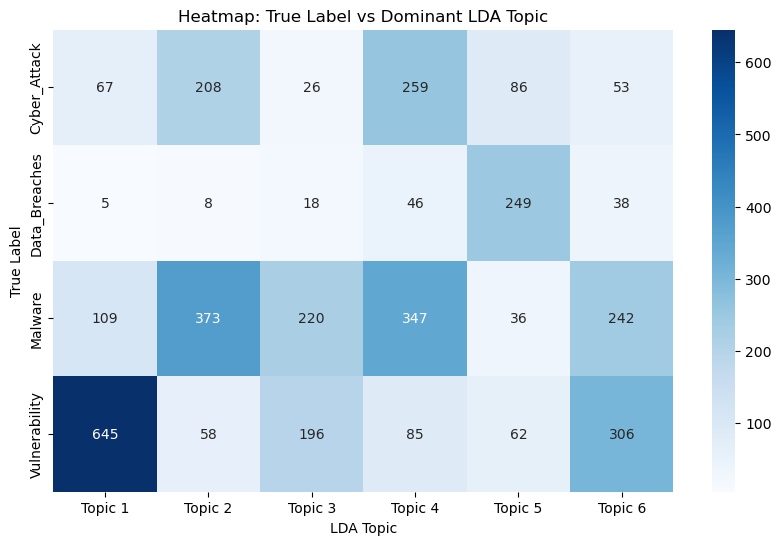

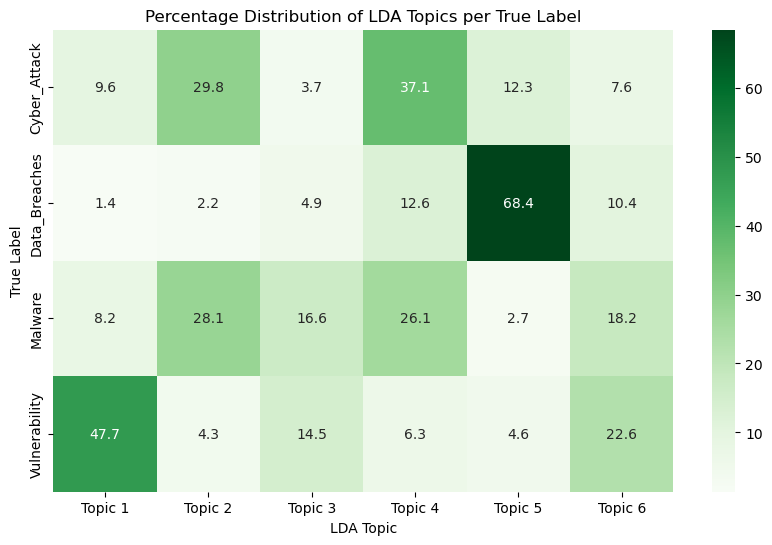

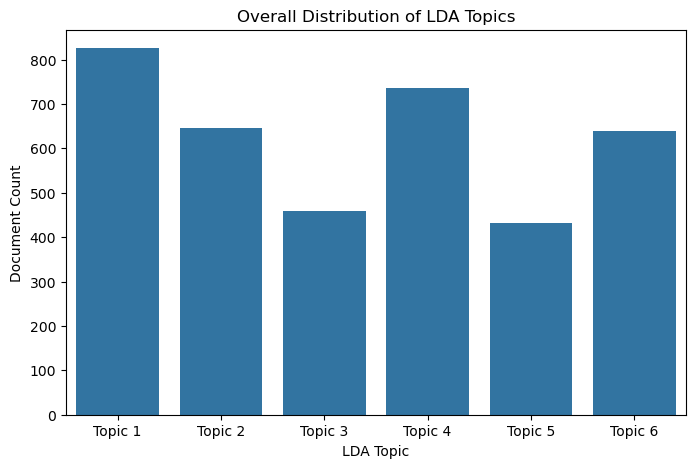

In [12]:
# STEP 9 - VISUALIZATIONS

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# VISUAL 1: Heatmap (raw counts)
ct = pd.crosstab(df["Label"], df["Dominant_Topic"])

ct.columns = [f"Topic {i+1}" for i in ct.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, cmap="Blues", fmt="d")
plt.title("Heatmap: True Label vs Dominant LDA Topic")
plt.xlabel("LDA Topic")
plt.ylabel("True Label")
plt.show()

# VISUAL 2: Percentage heatmap 
ct_pct = pd.crosstab(
    df["Label"],
    df["Dominant_Topic"],
    normalize="index"
) * 100

ct_pct.columns = [f"Topic {i+1}" for i in ct_pct.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(ct_pct.round(1), annot=True, cmap="Greens", fmt=".1f")
plt.title("Percentage Distribution of LDA Topics per True Label")
plt.xlabel("LDA Topic")
plt.ylabel("True Label")
plt.show()

# VISUAL 3: Bar plot of topic frequencies

topic_counts = df["Dominant_Topic"].value_counts().sort_index()
topic_labels = [f"Topic {i+1}" for i in topic_counts.index]

plt.figure(figsize=(8, 5))
sns.barplot(x=topic_labels, y=topic_counts.values)
plt.title("Overall Distribution of LDA Topics")
plt.xlabel("LDA Topic")
plt.ylabel("Document Count")
plt.show()